In [100]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GRU
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import keras
from keras import backend as K #转换为张量

 
file="D:\daily_adjusted_IBM.csv"
data=pd.read_csv(file)

close= data["close"].values.astype('float32')
close= close.reshape(-1,1)
print(close[:10])


[[145.46]
 [148.42]
 [145.22]
 [145.75]
 [144.75]
 [141.88]
 [144.24]
 [143.  ]
 [142.01]
 [141.57]]


In [101]:
train_size = int(len(close) * 0.80)

test_size = len(close) - train_size
train_set = close[0:train_size,:]
test_set = close[train_size:len(close),:]

train_set_ori = train_set

scaler = MinMaxScaler(feature_range=(0,1))
train_set = scaler.fit_transform(train_set)

x_train = []
y_train = []

for i in range(100, len(train_set)-7):
    x_train.append(train_set[i - 100:i, 0])
    y_train.append(train_set[i:i + 7, 0])

# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
print(test_set.shape)
print(test_set[:5])

(1083, 1)
[[96.79]
 [95.96]
 [97.31]
 [97.8 ]
 [98.42]]


In [102]:
x_train, y_train = np.array(x_train), np.array(y_train)
from itertools import chain
# = np.array(list(chain.from_iterable(x_train)))

# 此处整个数据集送入，送入样本数为x_train.shape[0]即2066组数据；输入60个开盘价，预测出第61天的开盘价，循环核时间展开步数为60; 每个时间步送入的特征是某一天的开盘价，只有1个数据，故每个时间步输入特征个数为1
#x_train_ex = x_train[0:1973760]

#x_train_ex = np.reshape(x_train_ex, (64, 60, 1))
# x_train = x_train.astype('float64')
# y_train = y_train.astype('float64')
x_train_tf = tf.convert_to_tensor(x_train)
y_train_tf = tf.convert_to_tensor(y_train)

x_train_tf = np.expand_dims(x_train_tf, axis=2)
y_train_tf = np.expand_dims(y_train_tf, axis=2)

print(y_train_tf)
print(y_train_tf.shape)



[[[0.09100375]
  [0.09051785]
  [0.09190622]
  ...
  [0.10335973]
  [0.10391507]
  [0.10884354]]

 [[0.39816752]
  [0.40823272]
  [0.43252817]
  ...
  [0.48167434]
  [0.47973076]
  [0.4670277 ]]

 [[0.9624462 ]
  [0.96327925]
  [0.9586284 ]
  ...
  [0.94203806]
  [0.9313481 ]
  [0.91808975]]

 ...

 [[0.4784812 ]
  [0.4727197 ]
  [0.47153965]
  ...
  [0.46737477]
  [0.46015552]
  [0.493475  ]]

 [[0.38504794]
  [0.41281417]
  [0.40455374]
  ...
  [0.40823272]
  [0.43252817]
  [0.50937116]]

 [[0.36325142]
  [0.38345137]
  [0.39448848]
  ...
  [0.3677635 ]
  [0.3554075 ]
  [0.36852702]]]
(4224, 7, 1)


In [103]:
# 测试集：csv表格中后300天数据
x_test = []
y_test = []
scaler = MinMaxScaler(feature_range=(0,1))
test_set = scaler.fit_transform(test_set)
# 利用for循环，遍历整个测试集，提取测试集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建300-60=240组数据。
for i in range(100, len(test_set)):
    x_test.append(test_set[i - 100:i, 0])
    y_test.append(test_set[i:i + 7, 0])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
# x
# x_test = x_test.reshape(64, 60, 1)
# x_test_tf = tf.convert_to_tensor(x_test)
# y_test_tf = tf.convert_to_tensor(y_test)
x_test = np.expand_dims(x_test, axis=2)
print(test_set[:5])




[[0.531059  ]
 [0.52049387]
 [0.5376781 ]
 [0.5439155 ]
 [0.5518074 ]]


d:\python 3.7\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


In [104]:
model = tf.keras.Sequential([
    #tf.keras.layers.Input(shape=(60)),
    #keras.Input(shape=(30, 7)),
    #keras.layers.InputLayer(input_shape=(32975, 30)),
#    Dense(7),
#     tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=2),
#                           input_shape=[None]),

#     Dropout(0.2),
    GRU(80, return_sequences=True),
    Dropout(0.2),
#     GRU(7, return_sequences=True),
#     Dropout(0.2),
    GRU(100),
    Dropout(0.2),
    Dense(7)
    
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.Huber()
              #loss='mean_absolute_error'
              #loss='squared_hinge'
             )  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值

checkpoint_save_path = "D:\checkpoint\stock.ckpt"
 
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')


history = model.fit(x_train_tf, y_train_tf, batch_size=64, epochs=300, validation_split=0.8, validation_freq=1,
                    callbacks=[cp_callback])

model.summary()


Epoch 1/300
14/14 [==============================] - 6s 252ms/step - loss: 0.0734 - val_loss: 0.0038
Epoch 2/300
14/14 [==============================] - 3s 230ms/step - loss: 0.0075 - val_loss: 0.0017
Epoch 3/300
14/14 [==============================] - 3s 225ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 4/300
14/14 [==============================] - 3s 227ms/step - loss: 0.0029 - val_loss: 5.9794e-04
Epoch 5/300
14/14 [==============================] - 3s 234ms/step - loss: 0.0025 - val_loss: 4.8146e-04
Epoch 6/300
14/14 [==============================] - 3s 242ms/step - loss: 0.0024 - val_loss: 5.0435e-04
Epoch 7/300
14/14 [==============================] - 3s 227ms/step - loss: 0.0023 - val_loss: 4.8787e-04
Epoch 8/300
14/14 [==============================] - 3s 228ms/step - loss: 0.0023 - val_loss: 4.5071e-04
Epoch 9/300
14/14 [==============================] - 3s 228ms/step - loss: 0.0021 - val_loss: 4.8186e-04
Epoch 10/300
14/14 [==============================] - 3s 228ms/step

In [109]:
predicted_stock_price_final = []
pre_set = []
#pre_set = test_set[:60]
for i in range(100, len(test_set)-7,7):
    pre_set.append(test_set[i - 100 : i, 0])
   # print(i)
    
for pre_set_for_train in pre_set:
    pre_set_for_train = np.expand_dims(pre_set_for_train, axis=0)
    pre_set_for_train = np.expand_dims(pre_set_for_train, axis=2)
    predicted_stock_price_tmp = model.predict(pre_set_for_train)
    predicted_stock_price_tmp = scaler.inverse_transform(predicted_stock_price_tmp)
    #print(predicted_stock_price_tmp)
    #print("predicted_stock_price_tmp",predicted_stock_price_tmp)
    predicted_stock_price_final = np.hstack((predicted_stock_price_final,predicted_stock_price_tmp[0]))
    #print(predicted_stock_price_final)
    
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = scaler.inverse_transform(test_set)
real_stock_price = real_stock_price[100:,:]
#real_stock_price = test_set[0][0]
real_stock_price_show=[]
for i in real_stock_price:
    real_stock_price_show.append(i[0])



In [106]:
print(len(test_set))
print(len(pre_set))
print(len(real_stock_price_show))

1083
140
983


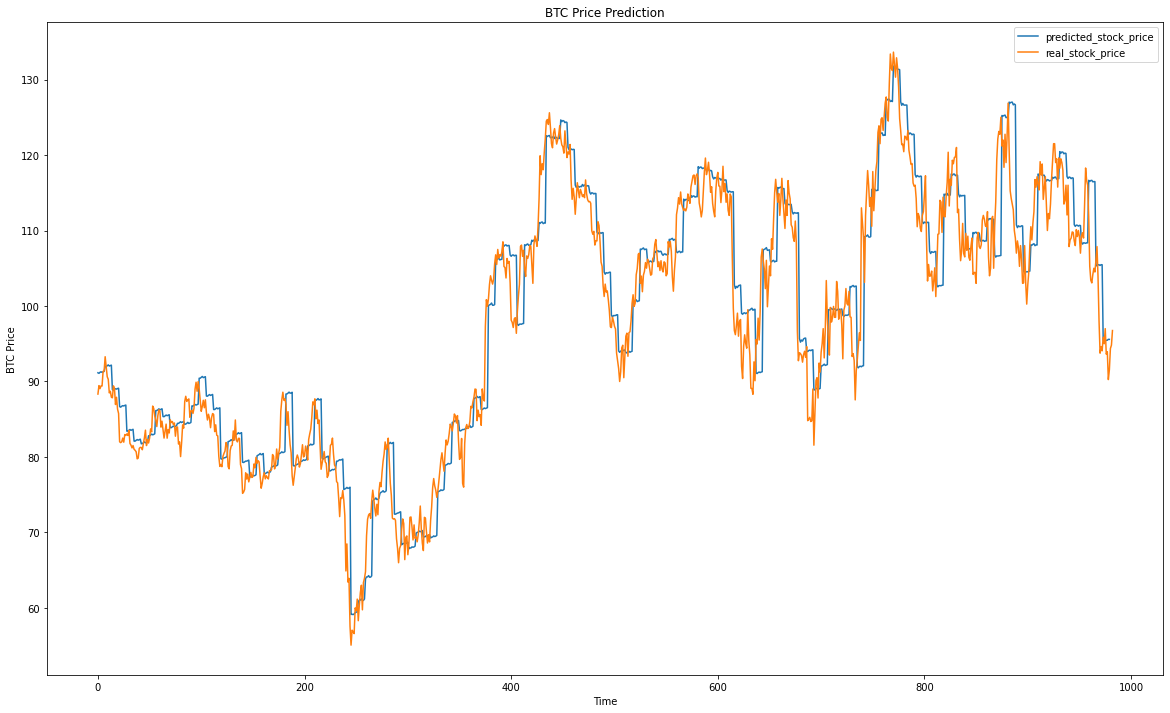

In [110]:
### 画出真实数据和预测数据的对比曲线


plt.figure(figsize=(20,12))
#把y轴的主刻度设置为10000的倍数
#y_major_locator=MultipleLocator(1000)
ax=plt.gca()
#ax为两条坐标轴的实例

#ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(300000,330000)



#my_y_ticks = np.arange(0, 500000, 1000)
#plt.yticks(my_y_ticks)
#plt.plot(real_stock_price, color='red', label='BTC Stock Price')
plt.plot(predicted_stock_price_final, '-', label='predicted_stock_price')
plt.plot(real_stock_price_show, '-', label='real_stock_price')
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()

#plt.show()
 